<a href="https://colab.research.google.com/github/dlbkv/AI-Step/blob/master/module4/hw14_regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Імпорт модулів

In [ ]:
import pandas as pd
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Дані про гриби

[посилання](https://www.kaggle.com/datasets/uciml/mushroom-classification)

In [ ]:
# трохи обробки даних
from sklearn.preprocessing import OrdinalEncoder

df = pd.read_csv('https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module3/data/mushrooms.csv')
df = df.drop(columns='veil-type')

encoder = OrdinalEncoder().set_output(transform='pandas')
df = encoder.fit_transform(df).astype(int)

columns = df.columns.delete(0)
data = df[columns]
df[columns] = (data - data.min()) / (data.max() - data.min())

Дані непогано збалансовані

In [ ]:
df['class'].value_counts()

class
0    4208
1    3916
Name: count, dtype: int64

In [ ]:
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,1.0,0.666667,0.444444,1.0,0.750,1.0,0.0,1.0,0.363636,...,0.666667,0.666667,0.875,0.875,0.666667,0.5,1.0,0.250,0.6,0.833333
1,0,1.0,0.666667,1.000000,1.0,0.000,1.0,0.0,0.0,0.363636,...,0.666667,0.666667,0.875,0.875,0.666667,0.5,1.0,0.375,0.4,0.166667
2,0,0.0,0.666667,0.888889,1.0,0.375,1.0,0.0,0.0,0.454545,...,0.666667,0.666667,0.875,0.875,0.666667,0.5,1.0,0.375,0.4,0.500000
3,1,1.0,1.000000,0.888889,1.0,0.750,1.0,0.0,1.0,0.454545,...,0.666667,0.666667,0.875,0.875,0.666667,0.5,1.0,0.250,0.6,0.833333
4,0,1.0,0.666667,0.333333,0.0,0.625,1.0,1.0,0.0,0.363636,...,0.666667,0.666667,0.875,0.875,0.666667,0.5,0.0,0.375,0.0,0.166667


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   class                     8124 non-null   int64  
 1   cap-shape                 8124 non-null   float64
 2   cap-surface               8124 non-null   float64
 3   cap-color                 8124 non-null   float64
 4   bruises                   8124 non-null   float64
 5   odor                      8124 non-null   float64
 6   gill-attachment           8124 non-null   float64
 7   gill-spacing              8124 non-null   float64
 8   gill-size                 8124 non-null   float64
 9   gill-color                8124 non-null   float64
 10  stalk-shape               8124 non-null   float64
 11  stalk-root                8124 non-null   float64
 12  stalk-surface-above-ring  8124 non-null   float64
 13  stalk-surface-below-ring  8124 non-null   float64
 14  stalk-co

Потрібно на основі інформації про гриб зрозуміти чи він їстівним(клас 1) `class`

# Завдання 1
Створіть клас Dataset для тренувальних та тестових даних

In [ ]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class DataSet(Dataset):
  def __init__(self, X, y) -> None:
    self.X = torch.FloatTensor(X.values)
    self.y = torch.FloatTensor(y.values)
    self.y = self.y.reshape(-1,1)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

X = df.drop(columns='class')
y = df['class']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

In [ ]:
dataset_train = DataSet(X_train, y_train)
dataset_test = DataSet(X_test, y_test)

# Завдання 2
Створіть DataLoader

In [ ]:
batch_size = 256
train_dl = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

# Завдання 3
Створіть нейромережу

In [ ]:
import numpy as np
from torch import nn
import torch.nn.functional as F

class Block(nn.Module):
  def __init__(self, input_dim, output_dim):
        super().__init__()

        self.linear = nn.Linear(input_dim, output_dim)
        self.linear1 = nn.Linear(output_dim, output_dim)
        self.bn1 = nn.BatchNorm1d(output_dim)
        self.linear2 = nn.Linear(output_dim, output_dim)
        self.bn2 = nn.BatchNorm1d(output_dim)
        self.linear3 = nn.Linear(output_dim, output_dim)
        self.bn3 = nn.BatchNorm1d(output_dim)

  def forward(self, x):
      x = self.linear(x)
      x = F.relu(x)

      out = self.linear1(x)
      out = self.bn1(out)
      out = F.relu(out)

      out = self.linear2(out)
      out = self.bn2(out)
      out = F.relu(out)

      out = self.linear3(out)
      out = self.bn3(out)
      out = F.relu(out)

      return out + x

In [ ]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        self.block1 = Block(input_dim, hidden_dim)
        self.block2 = Block(hidden_dim, hidden_dim//2)

        self.linear1 = nn.Linear(hidden_dim//2, hidden_dim//2)
        self.linear2 = nn.Linear(hidden_dim//2, hidden_dim//2)
        self.linear3 = nn.Linear(hidden_dim//2, hidden_dim//2)
        self.linear4 = nn.Linear(hidden_dim//2, output_dim)

    def forward(self, x):
        out = self.block1(x)

        out = self.block2(out)
        out = F.dropout(out, 0.05)

        out = self.linear1(out)
        out = F.relu(out)

        out = self.linear2(out)
        out = F.relu(out)

        out = self.linear3(out)
        out = F.relu(out)

        out = self.linear4(out)
        out = F.sigmoid(out)

        return out


    def predict(self, X, device='cpu'):
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
          y_pred = self.forward(X)

        return y_pred.cpu().numpy()


model = BinaryClassifier(21, 128, 1).to(device)
model

BinaryClassifier(
  (block1): Block(
    (linear): Linear(in_features=21, out_features=128, bias=True)
    (linear1): Linear(in_features=128, out_features=128, bias=True)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear2): Linear(in_features=128, out_features=128, bias=True)
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear3): Linear(in_features=128, out_features=128, bias=True)
    (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block2): Block(
    (linear): Linear(in_features=128, out_features=64, bias=True)
    (linear1): Linear(in_features=64, out_features=64, bias=True)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear2): Linear(in_features=64, out_features=64, bias=True)
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear3):

In [ ]:
from torchsummary import summary

summary(model, input_size=(21,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           2,816
            Linear-2                  [-1, 128]          16,512
       BatchNorm1d-3                  [-1, 128]             256
            Linear-4                  [-1, 128]          16,512
       BatchNorm1d-5                  [-1, 128]             256
            Linear-6                  [-1, 128]          16,512
       BatchNorm1d-7                  [-1, 128]             256
             Block-8                  [-1, 128]               0
            Linear-9                   [-1, 64]           8,256
           Linear-10                   [-1, 64]           4,160
      BatchNorm1d-11                   [-1, 64]             128
           Linear-12                   [-1, 64]           4,160
      BatchNorm1d-13                   [-1, 64]             128
           Linear-14                   

# Завдання 4
Визначте функцію втрат та оптимізатор, можливо графік швидкості навчання

In [ ]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)

In [ ]:
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Завдання 5
Натренуйте нейромережу.

In [ ]:
# @title Функція для тренування
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    '''
    Runs training loop for classification problems. Returns Keras-style
    per-epoch history of loss and accuracy over training and validation data.

    Parameters
    ----------
    model : nn.Module
        Neural network model
    optimizer : torch.optim.Optimizer
        Search space optimizer (e.g. Adam)
    loss_fn :
        Loss function (e.g. nn.CrossEntropyLoss())
    train_dl :
        Iterable dataloader for training data.
    val_dl :
        Iterable dataloader for validation data.
    metrics: list
        List of sklearn metrics functions to be calculated
    metrics_name: list
        List of matrics names
    epochs : int
        Number of epochs to run
    device : string
        Specifies 'cuda' or 'cpu'
    task : string
        type of problem. It can be regression, binary or multiclass

    Returns
    -------
    Dictionary
        Similar to Keras' fit(), the output dictionary contains per-epoch
        history of training loss, training accuracy, validation loss, and
        validation accuracy.
    '''

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['lr'] = []
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
              try:
                  history_train[name] += func(y, y_pred) * x.size(0)
              except:
                  if task == 'binary': y_pred_ = y_pred.round()
                  elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                  history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)

        scheduler.step()
        history['lr'].append(scheduler.get_last_lr())


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_dl, test_dl,
                epochs=40,
                metrics=[accuracy_score, roc_auc_score],
                device=device,
                task='binary')

train() called: model=BinaryClassifier, opt=Adam(lr=0.010000), epochs=40, device=cpu

Epoch    1    1sec	loss:      0.228	val_loss:      0.338	accuracy_score:      0.886	val_accuracy_score:       0.95	roc_auc_score:      0.943	val_roc_auc_score:      0.989	
Epoch    2    0sec	loss:     0.0138	val_loss:     0.0267	accuracy_score:      0.996	val_accuracy_score:      0.992	roc_auc_score:          1	val_roc_auc_score:          1	
Epoch    3    1sec	loss:    0.00964	val_loss:      0.121	accuracy_score:      0.997	val_accuracy_score:      0.974	roc_auc_score:          1	val_roc_auc_score:      0.999	
Epoch    4    0sec	loss:     0.0409	val_loss:     0.0882	accuracy_score:      0.991	val_accuracy_score:      0.986	roc_auc_score:      0.999	val_roc_auc_score:      0.996	
Epoch    5    0sec	loss:     0.0083	val_loss:     0.0088	accuracy_score:      0.997	val_accuracy_score:      0.998	roc_auc_score:          1	val_roc_auc_score:          1	
Epoch    6    0sec	loss:    0.00161	val_loss:   0.0002

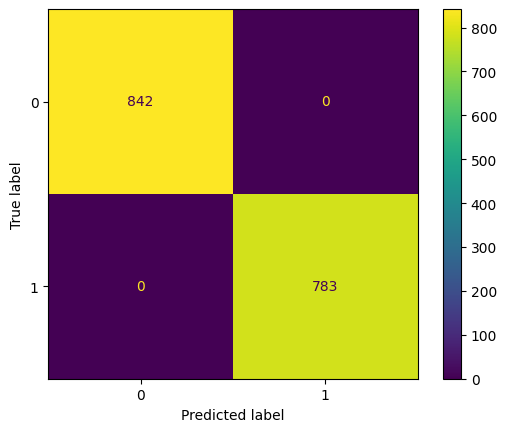

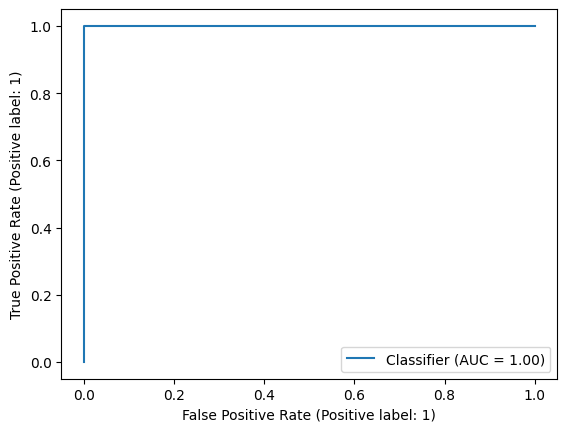

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred.round())
plt.plot()

RocCurveDisplay.from_predictions(y_test, y_pred, pos_label=1)

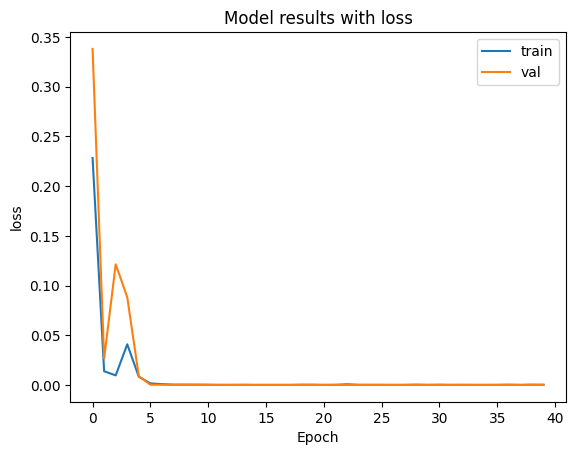

In [ ]:
def plot_metric(history, name):
  plt.title(f"Model results with {name}")
  plt.plot(history[name], label='train')
  plt.plot(history['val_'+name], label='val')
  plt.xlabel('Epoch')
  plt.ylabel(name)
  plt.legend()


plot_metric(history, 'loss')

# Завдання 6
Збережіть нейромережу та зробіть прогноз

In [ ]:
torch.save(model, 'model.pt')

In [ ]:
loaded_model = torch.load('model.pt')

In [ ]:
X_data = torch.FloatTensor([X.iloc[1,:].values])

In [ ]:
with torch.no_grad():
  print(loaded_model.predict(X_data).round())

[[0.]]
